In [14]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from model import Unet
from dataset import CRACK500
from utils import test_performance, get_F1

DEVICE = 'mps'

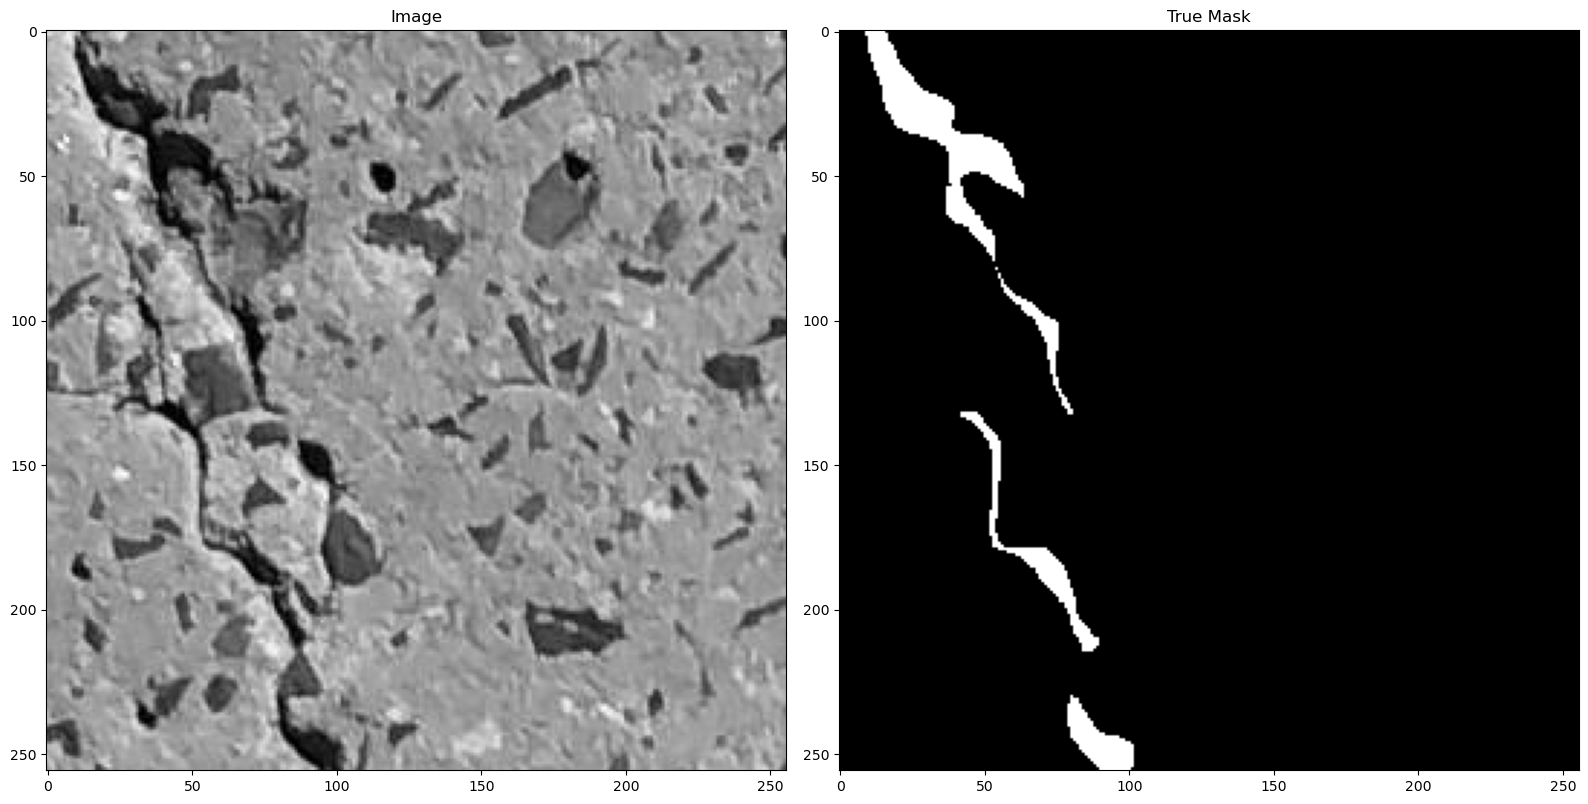

In [2]:
trainset = CRACK500(txt_file='data/train.txt', root_dir='data', train=True, data_augmentation=False)
image, mask = trainset[100]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(image.squeeze(), cmap=plt.cm.gray)
ax[0].set_title("Image")
ax[1].imshow(mask, cmap=plt.cm.gray)
ax[1].set_title("True Mask")
fig.tight_layout()
plt.show()

testset = CRACK500(txt_file='data/test.txt', root_dir='data', train=False, data_augmentation=False)
valset = CRACK500(txt_file='data/val.txt', root_dir='data', train=False, data_augmentation=False)

In [3]:
dataloader = DataLoader(trainset, batch_size=8, shuffle=True, num_workers=2)
n_train = len(trainset)

In [7]:
def train(dataloader, valset, epochs=2, name_model='unet'):

  unet = Unet().to(DEVICE)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(unet.parameters())


  losses = []
  f1s = []

  best_model = unet
  best_f1 = -np.inf

  since = time.time()

  for epoch in range(epochs):

    since_epoch = time.time()
    epoch_loss = 0.0

    for data in tqdm(dataloader):
      # get the inputs; data is a list of [inputs, labels]
      images = data[0].to(DEVICE)
      masks = data[1].to(DEVICE)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = unet(images)
      loss = criterion(outputs, masks)
      loss.backward()
      optimizer.step()

      # print statistics
      epoch_loss += loss.item()



    time_elapsed_epoch = time.time() - since_epoch

    print('Epoch completed in {:.0f}m {:.0f}s'.format(
          time_elapsed_epoch // 60, time_elapsed_epoch % 60))
    print('Epoch loss: %.3f' % (epoch_loss / n_train))

    print('Calculating F1 score on valset ...')
    f1 = get_F1(unet, valset, device=DEVICE)
    print(f'F1 score on validation set is {f1}')

    if f1 > best_f1:
      best_f1 = f1
      best_model = unet
      print('Currently this model will be saved')

    losses.append(epoch_loss)
    f1s.append(f1)

  print('Finished Training')

  time_elapsed = time.time() - since

  print('Training completed in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))

  torch.save(best_model, f'models/{name_model}')

  fig = plt.figure()

  ax = fig.add_subplot(1, 2, 1)
  bx = fig.add_subplot(1, 2, 2)

  ax.plot(losses)
  ax.set_xlabel('epochs')
  ax.set_ylabel('loss')
  ax.set_title('Epoch Loss')

  bx.plot(f1s)
  bx.set_xlabel('epochs')
  bx.set_ylabel('F1 score')
  bx.set_title('F1 score on validation set')

  plt.show()

  return best_model

100%|██████████| 237/237 [04:36<00:00,  1.17s/it]


Epoch completed in 4m 37s
Epoch loss: 0.023
Calculating F1 score on valset ...
F1 score on validation set is 0.5460414650221135
Currently this model will be saved


100%|██████████| 237/237 [04:46<00:00,  1.21s/it]


Epoch completed in 4m 47s
Epoch loss: 0.014
Calculating F1 score on valset ...
F1 score on validation set is 0.5547691694665641
Currently this model will be saved
Finished Training
Training completed in 11m 8s


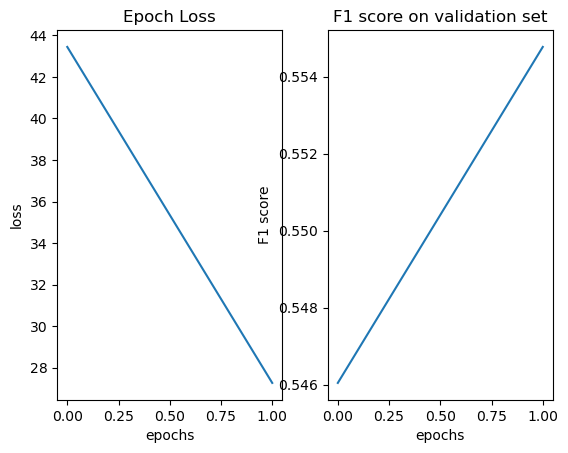

In [8]:
unet = train(dataloader, valset, epochs=2,)

#Visualize some prediction (on cropped val image to be improved for performance evaluation):
Images size must be multiple of 32.






torch.Size([1, 352, 640]) torch.Size([352, 640])
torch.Size([1, 352, 640]) torch.Size([352, 640])


<Figure size 640x480 with 0 Axes>

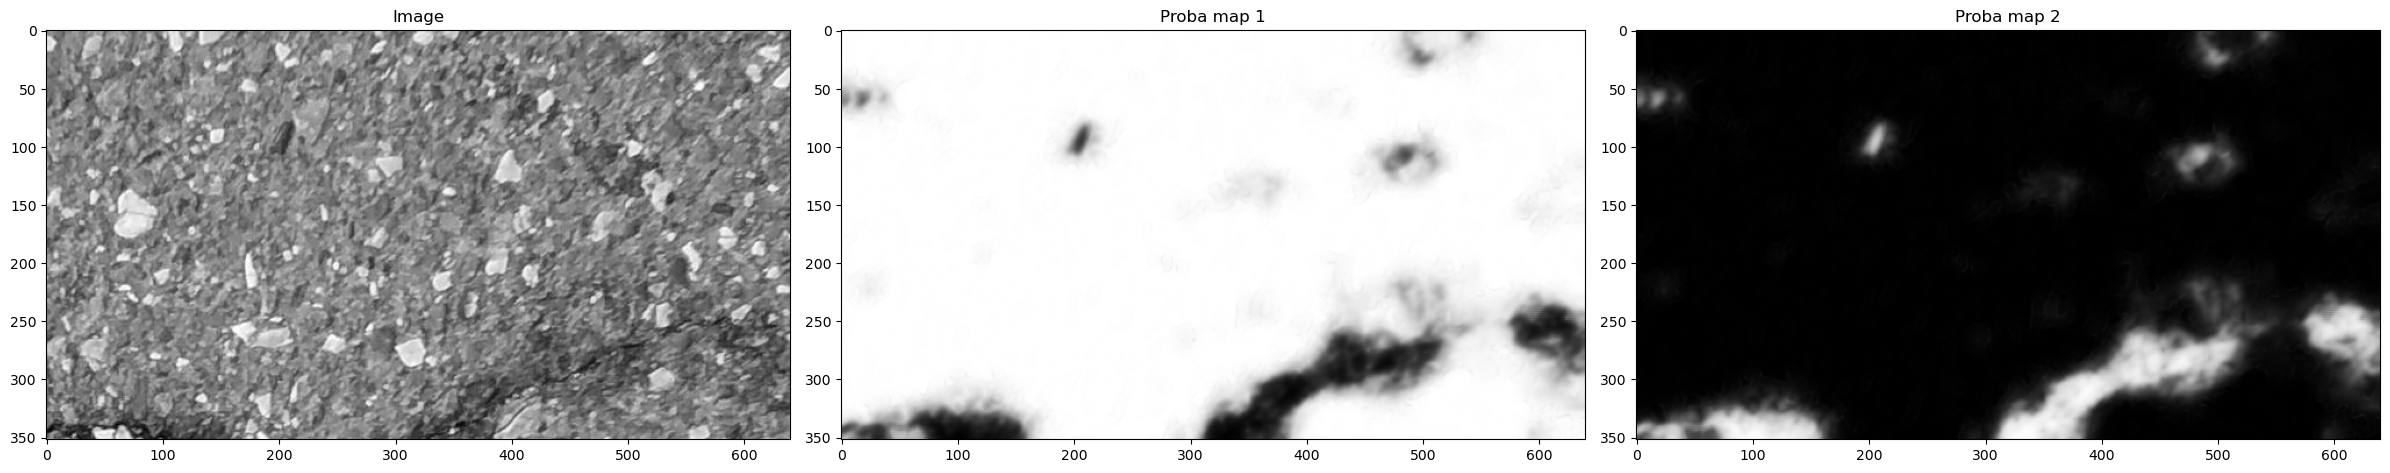

<Figure size 640x480 with 0 Axes>

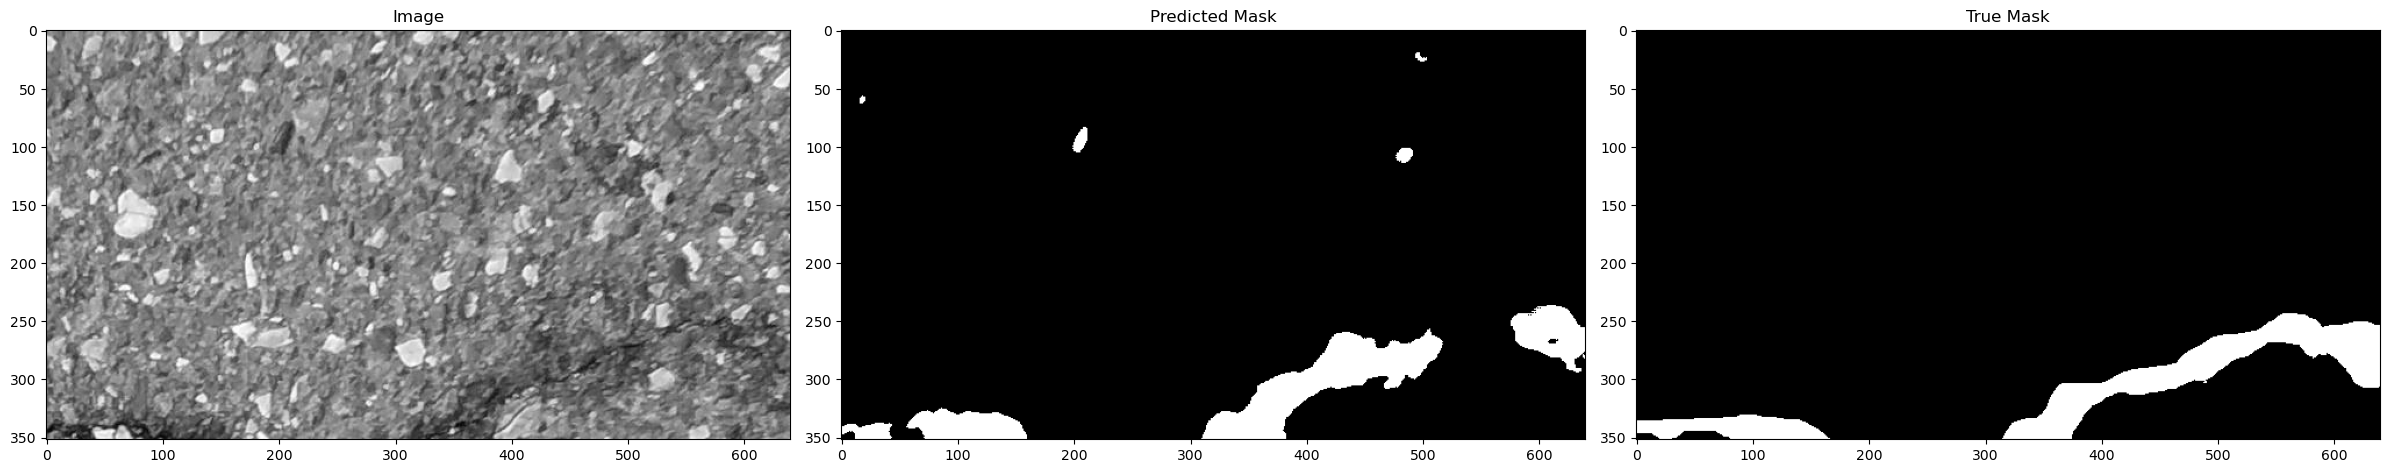

In [10]:
i = np.random.randint(len(valset))
image, mask = valset[i]
print(image.size(), mask.size())
h,w = mask.size()
nh = (h//32)*32
nw = (w//32)*32
image = image[:,:nh,:nw]
mask = mask[:nh,:nw]
print(image.size(), mask.size())

with torch.no_grad():
  out = unet(torch.unsqueeze(image.to(DEVICE),0))
  predprob = F.softmax(out,dim=1).to('cpu')
predprob1 = predprob[0,0,:,:].squeeze()
predprob2 = predprob[0,1,:,:].squeeze()
predmask = torch.argmax(out.squeeze(), dim=0).to('cpu')

plt.figure();

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(image.squeeze(), cmap=plt.cm.gray)
ax[0].set_title("Image")
ax[1].imshow(predprob1, cmap=plt.cm.gray)
ax[1].set_title("Proba map 1")
ax[2].imshow(predprob2, cmap=plt.cm.gray)
ax[2].set_title("Proba map 2")
fig.tight_layout()
plt.show();

plt.figure()

fig, ax = plt.subplots(1, 3, figsize=(24, 8))
ax[0].imshow(image.squeeze(), cmap=plt.cm.gray)
ax[0].set_title("Image")
ax[1].imshow(predmask, cmap=plt.cm.gray)
ax[1].set_title("Predicted Mask")
ax[2].imshow(mask, cmap=plt.cm.gray)
ax[2].set_title("True Mask")
fig.tight_layout()
plt.show();



In [15]:
test_performance(unet, testset, device=DEVICE)

test_performance: Image  99  /  1124
test_performance: Image  199  /  1124
test_performance: Image  299  /  1124
test_performance: Image  399  /  1124
test_performance: Image  499  /  1124
test_performance: Image  599  /  1124
test_performance: Image  699  /  1124
test_performance: Image  799  /  1124
test_performance: Image  899  /  1124
test_performance: Image  999  /  1124
test_performance: Image  1099  /  1124
6412836 232470400.0 6580883.0 7750649
precision 0.4935
recall 0.4528
F1score 0.4723
